In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
import ast
import os
import re

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from collections import Counter
from sklearn.pipeline import Pipeline
import joblib

# pd.options.display.max_rows = 16
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = "{:.1f}".format

## EDA for User Information

In [25]:
df = pd.read_csv('lastfm_user_clean.csv')
# [['Username', 'country', 'registered_year', 'track_count', 'artist_count', 'track_name', 'artist_name', 'rank', 'playcount']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Username          9999 non-null   object
 1   Top_50            9999 non-null   object
 2   Loved             9999 non-null   object
 3   playcount         9999 non-null   int64 
 4   artist_count      9999 non-null   int64 
 5   track_count       9999 non-null   int64 
 6   album_count       9999 non-null   int64 
 7   country           6773 non-null   object
 8   type              9999 non-null   object
 9   registered_year   9999 non-null   int64 
 10  registered_month  9999 non-null   int64 
 11  registered_day    9999 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 937.5+ KB


In [26]:
df.head(6)

,Username,Top_50,Loved,playcount,artist_count,track_count,album_count,country,type,registered_year,registered_month,registered_day
0,emosoup,"[('Higher', 'Sleep Token', '1', '1321'), ('The...","[('Obsidian', 'Viscera'), ('yes, and?', 'Arian...",187276,3386,13520,6171,United States,subscriber,2015,8,31
1,gibelotte,"[('DAYWALKER! (feat. Corpse)', 'Machine Gun Ke...","[('Fragile', 'Young Cub'), (""Sarabeth's Song"",...",96134,4453,13123,6514,United States,user,2013,11,7
2,riddy_pr,"[('Will We Talk?', 'Sam Fender', '1', '291'), ...",[],46389,2495,11923,5189,United Kingdom,user,2018,12,31
3,TheGirlNamedSig,"[('Be Quiet and Drive (Far Away)', 'Deftones',...","[(""Beaver O'Lindy"", 'Sparks'), ('Age of Consen...",34006,2380,6994,3987,NaN,user,2017,1,10
4,eventually_,"[('Light', 'Tag Shai', '1', '6142'), ('Old You...","[('Clock Hands', 'Harlow Road'), ('Waterslides...",459131,12363,57910,15197,United States,subscriber,2013,12,1
5,in_wavelengths,"[(""Sparky's Dream"", 'Teenage Fanclub', '1', '2...","[('Bones', 'Radiohead')]",95117,5135,17422,8519,United States,user,2017,12,31


In [27]:
df.nunique()

Username            9999
Top_50              9999
Loved               7739
playcount           9756
artist_count        5501
track_count         8797
album_count         7063
country              156
type                   4
registered_year       23
registered_month      12
registered_day        31
dtype: int64

In [28]:
# Descriptive Statistics
numerical_cols = ['playcount',
                  'artist_count',
                  'track_count',
                  'album_count',
                  'registered_year',
                #   'registered_month',
                #   'registered_day'
                  ]

descriptive_stats = df[numerical_cols].describe().loc[['min', 'max', 'mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['min', 'max', 'mean', 'std', 'median']
descriptive_stats['mode'] = df[numerical_cols].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(df[x]) for x in numerical_cols]
descriptive_stats['kurtosis'] = [stats.kurtosis(df[x], fisher=False) for x in numerical_cols]
descriptive_stats['skewness'] = [stats.skew(df[x]) for x in numerical_cols]
descriptive_stats

,min,max,mean,std,median,mode,mad,kurtosis,skewness
playcount,0.0,8463249.0,113424.574857,166633.447294,74937.0,1.0,48314.0,673.825403,16.505325
artist_count,0.0,139439.0,3621.195820,5593.181496,2199.0,1.0,1343.0,138.894310,8.750940
track_count,0.0,427379.0,20761.056706,27430.705322,12707.0,1.0,8159.0,41.122364,4.764907
album_count,0.0,192746.0,6917.185819,9592.894108,4247.0,0.0,2655.0,71.067521,6.086107
registered_year,2002.0,2024.0,2015.903990,5.485855,2018.0,2021.0,4.0,1.891122,-0.457327


As we can observe from discriptive statistics, the various music playing counts of users are quite postively skewed. The positive skewness of music playing counts suggests that most users have relatively low playcounts, but there are a few users with extremely high playcounts, resulting in the right-skewed distribution. Out of these, the four counts metrics have mode value of 0 or 1. On a first look this could mean that a significant number of users have played very few songs or albums, respectively. For example, it could be due to inactive accounts, new users who have not started using the platform yet. However, based on our understanding of the Last.fm platform, it could also be due to users who listen to music but do not scrobble their plays to Last.fm, since all users have non-empty `Top_50` songs lists. 

The users have a wide range of registration year from 2002 to 2024. Moving on, we plot histograms to visualize the distribution of these numerical columns. 

<Figure size 800x550 with 0 Axes>

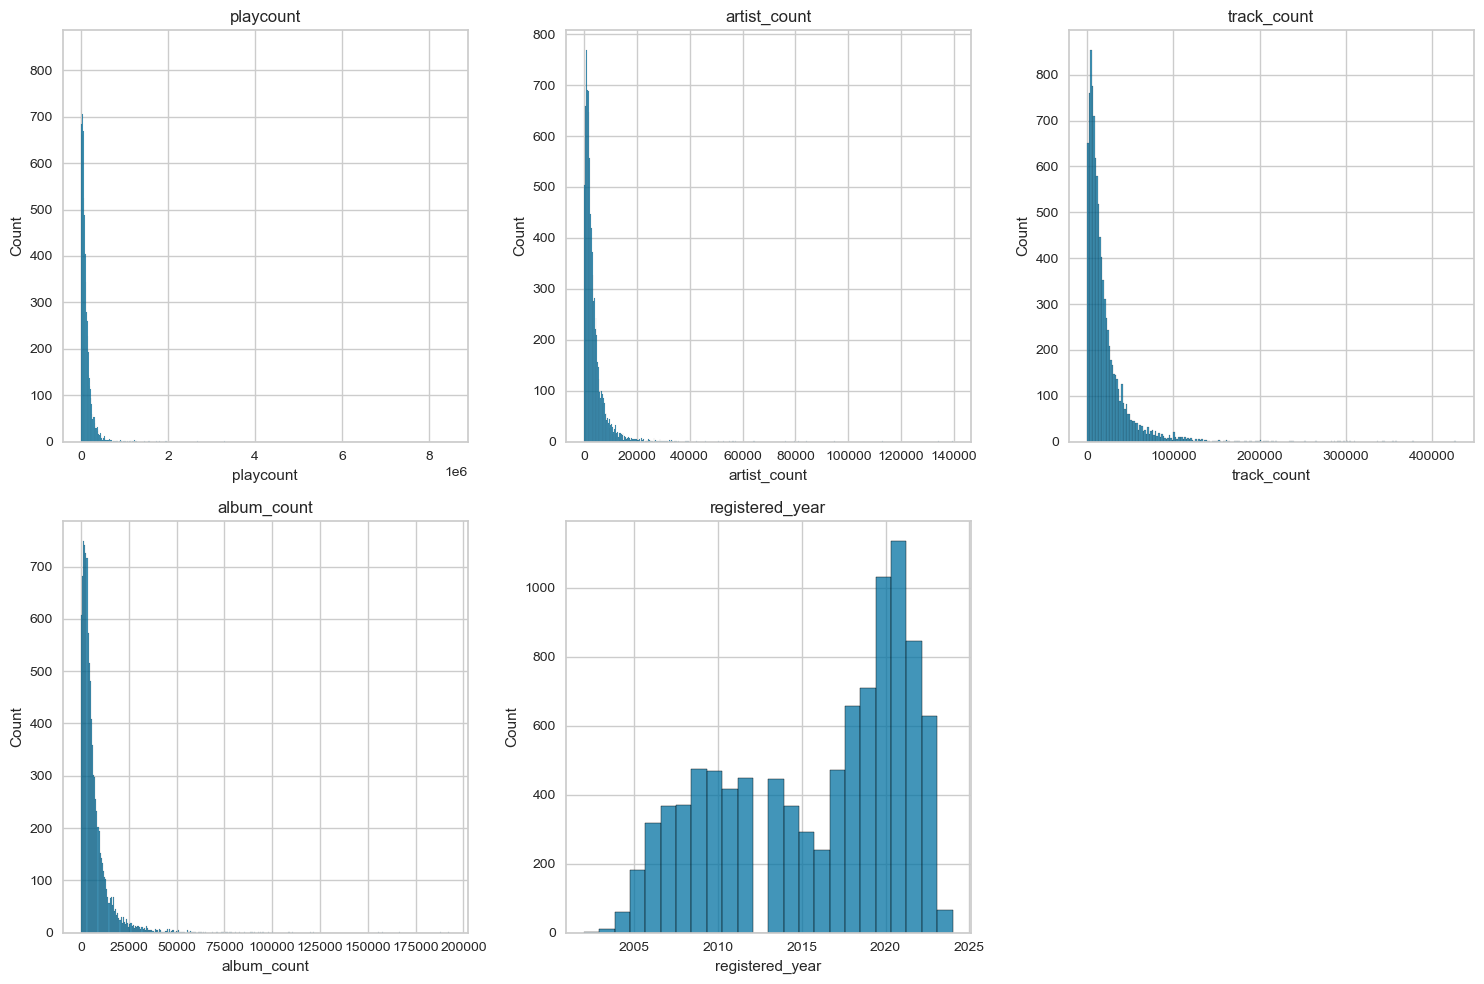

In [24]:
# histogram of features to observe the distribution of values
plt.clf()
num_features = len(numerical_cols)
num_cols = 3  # Maximum number of subplots per row
num_rows = (num_features - 1) // num_cols + 1
plt.figure(figsize=(5 * num_cols, 5 * num_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

From the above analysis and visualization, we find `track_count` to be the most representative music playing counts among the four for users' activeness on the platform. There are extreme outliers in this value, therefore, we have decided to transform it into categorical variable, though risking losing some information. 

In [62]:
# transform track_count to categorical
df['active_category'] = pd.qcut(df['track_count'], q=5, labels=["most inactive", "inactive", "medium", "active", "most active"])
print(df['active_category'].value_counts())
# plt.figure(figsize=(8, 6))
# sns.barplot(x='active_category', y='track_count', data=df, estimator=np.mean)
# plt.xlabel('Activeness Category')
# plt.ylabel('Mean Track Count')
# plt.title('Mean Track Count for Different Activeness Levels', fontsize=12, fontweight='bold')
# plt.xticks(rotation=45)
# plt.show()

active_category
most inactive    2000
inactive         2000
active           2000
most active      2000
medium           1999
Name: count, dtype: int64


In [36]:
# observe how many users are in each type to see if this feature is relevant in recommendation
df['type'].value_counts()

type
user          8521
subscriber    1473
staff            4
mod              1
Name: count, dtype: int64

We can see that except for users who did not indicate their countries on Last.fm platform, most users come from the US, Brazil, UK, Canada and Australia.

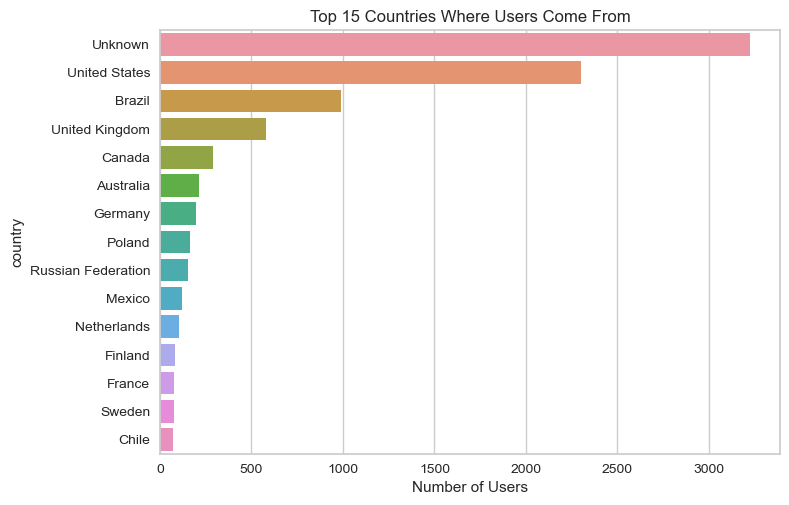

In [39]:
# Observe where users come from
df['country'] = df['country'].fillna('Unknown')
countries = df.groupby(['country']).agg({"Username":'count'}).reset_index()
countries = countries.sort_values(by = 'Username', ascending = False).head(15)
sns.barplot(y = countries.country, x = countries.Username).set(title = 'Top 15 Countries Where Users Come From')
plt.xlabel('Number of Users')
plt.show()

We can observe from heatmap that the various count metrics are quite highly correlated.

<Figure size 800x550 with 0 Axes>

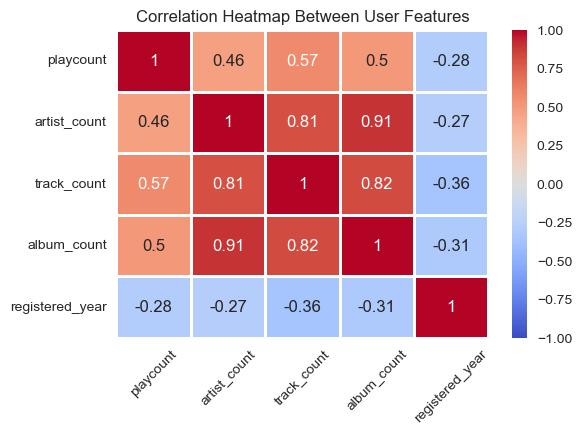

In [48]:
# heatmap to observe the correlation between numerical features 
plt.clf()
corr_df=df[numerical_cols].corr(method='pearson')
plt.figure(figsize=(6,4))
heatmap=sns.heatmap(corr_df, annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap="coolwarm", linewidths=2)
heatmap.set_title('Correlation Heatmap Between User Features')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

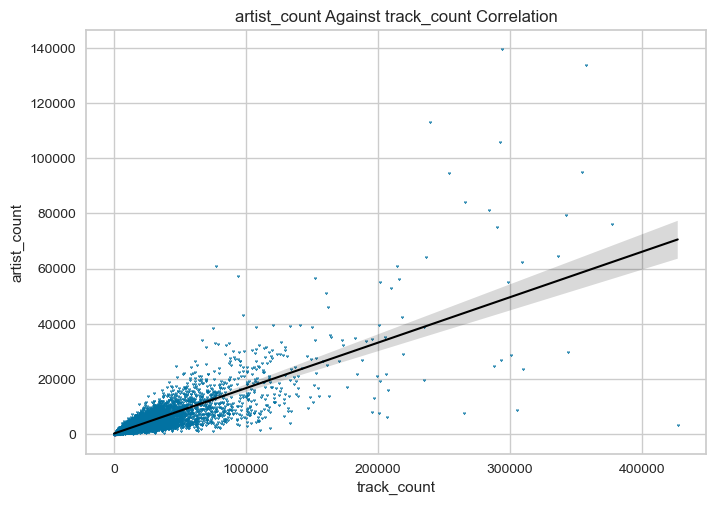

In [58]:
# observe the correlation between artist_count and track_count
plt.clf()
sns.regplot(data=df, y='artist_count', x='track_count', scatter_kws={'s':2}, marker='2', line_kws={"color": "black", 'linewidth':1.5}).set(title='artist_count Against track_count Correlation')
plt.show()

### Next we do feature engineering on the user features.

In [2]:
user_songs_filtered = pd.read_csv('user_songs_filtered.csv')[['Username', 'country', 'registered_year', 'track_count', 'artist_count', 'track_name', 'artist_name', 'rank', 'playcount']]
user_songs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393120 entries, 0 to 393119
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Username         393120 non-null  object
 1   country          393120 non-null  object
 2   registered_year  393120 non-null  int64 
 3   track_count      393120 non-null  int64 
 4   artist_count     393120 non-null  int64 
 5   track_name       393120 non-null  object
 6   artist_name      393120 non-null  object
 7   rank             393120 non-null  int64 
 8   playcount        393120 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 27.0+ MB


In [3]:
def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "_" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

def users_eng(df, columns):
    df = df[columns]
    df_keep = df[['Username', 'track_name', 'artist_name', 'rank', 'playcount',
                  'country'
                  ]]
    df['log_total_track_count'] = np.log1p(df['track_count'])
    df['log_total_artist_count'] = np.log1p(df['artist_count'])
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(df[['log_total_track_count', 'log_total_artist_count']]), columns = ['log_total_track_count', 'log_total_artist_count']) 

    df['active_category'] = pd.qcut(df['track_count'], q=5, labels=["most inactive", "inactive", "medium", "active", "most active"])
    ohe_active = ohe_prep(df, 'active_category', 'activeness')
    # df['country'] = df['country'].fillna('Unknown')
    # ohe_country = ohe_prep(df, 'country', 'country')

    ## concat to create final df
    eng_df = pd.concat([df_keep, floats_scaled, ohe_active, 
                        # ohe_country,
                        ], axis = 1)
    
    return eng_df

In [4]:
users_eng_df = users_eng(user_songs_filtered, ['Username', 'country', 'track_count', 'artist_count', 'track_name', 'artist_name', 'rank', 'playcount'])
users_eng_df.head()

,Username,track_name,artist_name,rank,playcount,country,log_total_track_count,log_total_artist_count,activeness_most inactive,activeness_inactive,activeness_medium,activeness_active,activeness_most active
0,emosoup,Higher,Sleep Token,1,1321,United States,0.740725,0.686149,False,False,True,False,False
1,maiconslavieiro,Higher,Sleep Token,21,151,Brazil,0.766376,0.741361,False,False,False,True,False
2,velenious,Higher,Sleep Token,19,1259,United States,0.808702,0.766860,False,False,False,False,True
3,Antimemetic,Higher,Sleep Token,32,29,United States,0.646481,0.554484,True,False,False,False,False
4,frankcreature,Higher,Sleep Token,43,43,Czech Republic,0.610178,0.553889,True,False,False,False,False


In [5]:
users_eng_df.to_csv('users_feature_eng.csv', index = False)

## EDA and Feature Engineering for Songs

feature description:
The dataset contains audio features and lyrics features of songs and information (artist, title, number of listeners and playcount) we collected from Last.fm.

- listeners: number of listeners recorded on last.fm
- total_playcount: total number of playcount recorded on last.fm
- top_tags: top tags for a song, they can be user-generated on last.fm
- profanity_density: profanity level from feature engineering of the lyrics
- emotion1/2: top emotions of the song from feature engineering of the lyrics 
- Zero Crossing Rate: the rate at which the sound signal changes from positive to negative and vice versa. This feature is usually used for speech recognition and music information retrieval. Music genre with high percussive sound like rock or metal usually have high Zero Crossing Rate than other genres.
- Tempo BMP (beats per minute): Tempo is the number of beat per one minute.
- Spectral Centroid: This variable represents brightness of a sound by calculating the center of sound spectrum (where the sound signal is at its peak). We can also plot it into a wave form.
- Mel-Frequency Cepstral Coefficients: The Mel frequency Cepstral coefficients (MFCCs) of a signal are a small set of features that describes the overall shape of a spectral envelope. It imitates characteristics of human voice.
- Chroma Frequencies: Chroma feature represents the tone of music or sound by projecting its sound spectrum into a space that represents musical octave. This feature is usually used in chord recognition task.

In [2]:
songs_all = pd.read_csv('unique_songs_features_complete.csv',
                        na_filter=False  #because some track_name and artist_name are called 'null', other features do not have missing values based on previous inspection during dataset construction
).drop('lyrics', axis=1)

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
songs_all['toptags'] = songs_all['toptags'].apply(safe_eval)
songs_all.info()

# Converting song duration from milliseconds to minutes
songs_all['duration']=songs_all['duration_ms'].apply(lambda x : round((x/60000),2))
songs_all = songs_all.drop('duration_ms', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230676 entries, 0 to 230675
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_name_original   230676 non-null  object 
 1   artist_name_original  230676 non-null  object 
 2   duration_ms           230676 non-null  float64
 3   listeners             230676 non-null  float64
 4   total_playcount       230676 non-null  float64
 5   toptags               230676 non-null  object 
 6   profanity_density     230676 non-null  float64
 7   polarity              230676 non-null  float64
 8   subjectivity          230676 non-null  float64
 9   emotion1              230676 non-null  object 
 10  emotion1_score        230676 non-null  float64
 11  emotion2              230676 non-null  object 
 12  emotion2_score        230676 non-null  float64
 13  mfcc                  230676 non-null  object 
 14  chroma                230676 non-null  object 
 15  

In [7]:
# convert mfcc and chroma to array of numbers
def convert_to_float_list(s):
    # extract floating-point numbers
    # float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d+", s)
    float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d*\.\d+\s*|\d+\s*", s)
    # convert to list of floats
    float_list = [float(num) for num in float_numbers]
    return float_list

songs_all['mfcc'] = songs_all['mfcc'].apply(convert_to_float_list)
songs_all['chroma'] = songs_all['chroma'].apply(convert_to_float_list)
songs_all.head()

,track_name_original,artist_name_original,listeners,total_playcount,toptags,profanity_density,polarity,subjectivity,emotion1,emotion1_score,emotion2,emotion2_score,mfcc,chroma,rms,spectral_centroid,zcr,tempo,duration
0,One Look,Leo,8973.0,88557.0,"[pop, english, leodasun]",0.000000,-0.00143,0.50357,positive,0.129932,negative,0.071952,"[94.341545, 131.62889, 22.428738, 50.270664, 5...","[0.45004523, 0.45005292, 0.57855475, 0.5422693...",0.275240,2978.396347,0.062171,129.199219,2.60
1,Cradle,Mudvayne,86366.0,368525.0,"[Nu Metal, metal, math metal, alternative meta...",0.040936,-0.28963,0.66382,negative,0.111774,disgust,0.054927,"[153.13193, 125.41709, 35.41838, 41.12251, 9.5...","[0.610627, 0.52234715, 0.48563012, 0.516958, 0...",0.151819,3075.841535,0.077126,172.265625,5.23
2,Reading YouTube Comments,Drug Church,7399.0,38545.0,[],0.000000,-0.12500,0.34375,negative,0.234642,fear,0.171831,"[72.94578, 126.77503, 46.73466, 45.38154, 19.5...","[0.5410768, 0.56112826, 0.5285746, 0.5264109, ...",0.249417,3382.053061,0.078146,178.205819,2.87
3,Tissues,YUNGBLUD,59233.0,481214.0,"[seen live, rock]",0.000000,0.03286,0.58913,positive,0.178898,joy,0.143101,"[29.943943, 134.54782, 46.5182, 55.03315, 29.2...","[0.4032532, 0.40510523, 0.33724827, 0.41406393...",0.318193,3362.386296,0.078008,90.666118,0.00
4,The Games We Play,Pusha T,270156.0,2858530.0,"[hardcore hip hop, rap, Energetic, Gangsta Rap...",0.022523,0.08550,0.46763,positive,0.156240,joy,0.073203,"[86.60968, 117.12216, 40.658672, 45.47891, 19....","[0.2931717, 0.31128934, 0.44186398, 0.3576136,...",0.300682,3379.955173,0.072801,156.605114,2.77


In [8]:
# create features from mfcc and chroma
def calculate_mean_var(lst):
    if len(lst) > 0:
        audio_mean = np.mean(lst)
        audio_var = np.var(lst)
        return audio_mean, audio_var
    else:
        return np.nan, np.nan
songs_all[['mfcc_mean', 'mfcc_var']] = pd.DataFrame(songs_all['mfcc'].apply(calculate_mean_var).tolist(), index=songs_all.index)
songs_all[['chroma_mean', 'chroma_var']] = pd.DataFrame(songs_all['chroma'].apply(calculate_mean_var).tolist(), index=songs_all.index)
# feature scaling
def feature_scaling(ls):
    if len(ls) > 0:
        return sklearn.preprocessing.scale(ls)
    else:
        return ls
songs_all['mfcc_scaled'] = songs_all['mfcc'].apply(feature_scaling)
# songs_all['chroma_scaled'] = songs_all['chroma'].apply(feature_scaling)
# songs_all.head()


In [116]:
songs_all['mfcc_features'] = songs_all['mfcc_scaled'].apply(lambda x: np.array(x).flatten())
mfcc_features = np.stack(songs_all['mfcc_features'])
mfcc_features = pd.DataFrame(mfcc_features)
mfcc_features.columns = [f'mfcc_{i+1}' for i in range(mfcc_features.shape[1])]
# mfcc_features.min()

In [9]:
# handling outliers which may interfere with the performance of ML algorithm
songs_all.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
listeners,230676.0,58438.167667,1.267648e+05,0.000000e+00,3385.000000,16277.500000,56116.250000,3.115370e+06
total_playcount,230676.0,419861.943989,1.354466e+06,0.000000e+00,14943.000000,80809.500000,319284.250000,1.476307e+08
profanity_density,230676.0,0.005622,1.551479e-02,0.000000e+00,0.000000,0.000000,0.003135,4.565217e-01
polarity,230676.0,0.041686,1.765006e-01,-1.000000e+00,-0.057910,0.040040,0.136390,1.000000e+00
subjectivity,230676.0,0.513227,1.414490e-01,0.000000e+00,0.438180,0.510710,0.592620,1.000000e+00
emotion1_score,230676.0,0.153276,7.619604e-02,2.175910e-06,0.103442,0.141179,0.187980,1.217819e+00
emotion2_score,230676.0,0.098316,4.579637e-02,1.296579e-08,0.067459,0.093237,0.122729,6.313336e-01
rms,230676.0,0.215476,8.394138e-02,0.000000e+00,0.155995,0.220500,0.274001,8.126503e-01
spectral_centroid,230676.0,2658.276625,8.411375e+02,0.000000e+00,2100.404925,2714.204124,3245.092742,1.320376e+04
zcr,230676.0,0.057735,2.425705e-02,0.000000e+00,0.039618,0.056677,0.073797,7.073940e-01


As we can see in the statistical summary, the numerical values in song features are not on the same scale, therefore we need to scale them before feeding into ML models. Next, we do logarithmic transformation for values in very large range.

In [10]:
# Logarithmic Transformation
songs_all['log_total_playcount'] = np.log1p(songs_all['total_playcount'])
songs_all['log_listeners'] = np.log1p(songs_all['listeners'])

Next we observe the distribution of relevant numerical columns

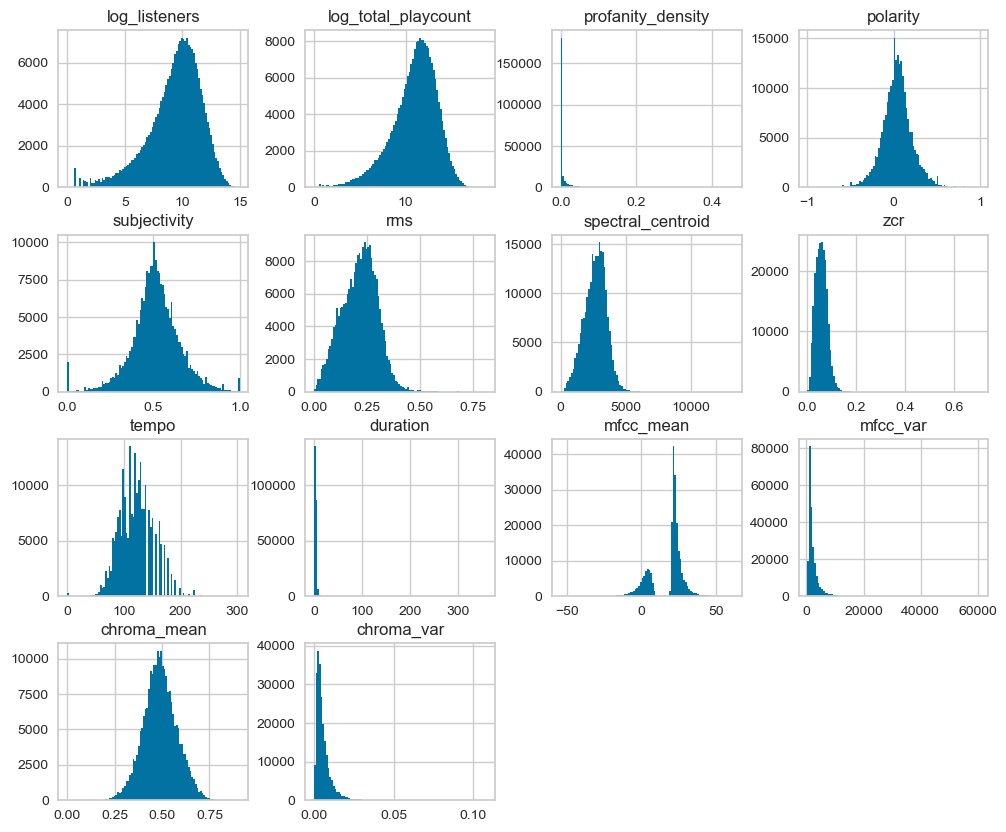

In [11]:
# observe the distribution of relevant numerical columns
numerical_features = ['log_listeners', 'log_total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'duration', 'mfcc_mean', 'mfcc_var', 'chroma_mean', 'chroma_var']
ax = songs_all[numerical_features].hist(figsize = (12, 10), bins = 100)

we can see the distributions of profanity_density, duration and also some audio feature columns are quite skewed.
We will deal with the outliers before feeding data into ML models. 

Next we use heatmap to observe the correlation between numerical features 

<Figure size 800x550 with 0 Axes>

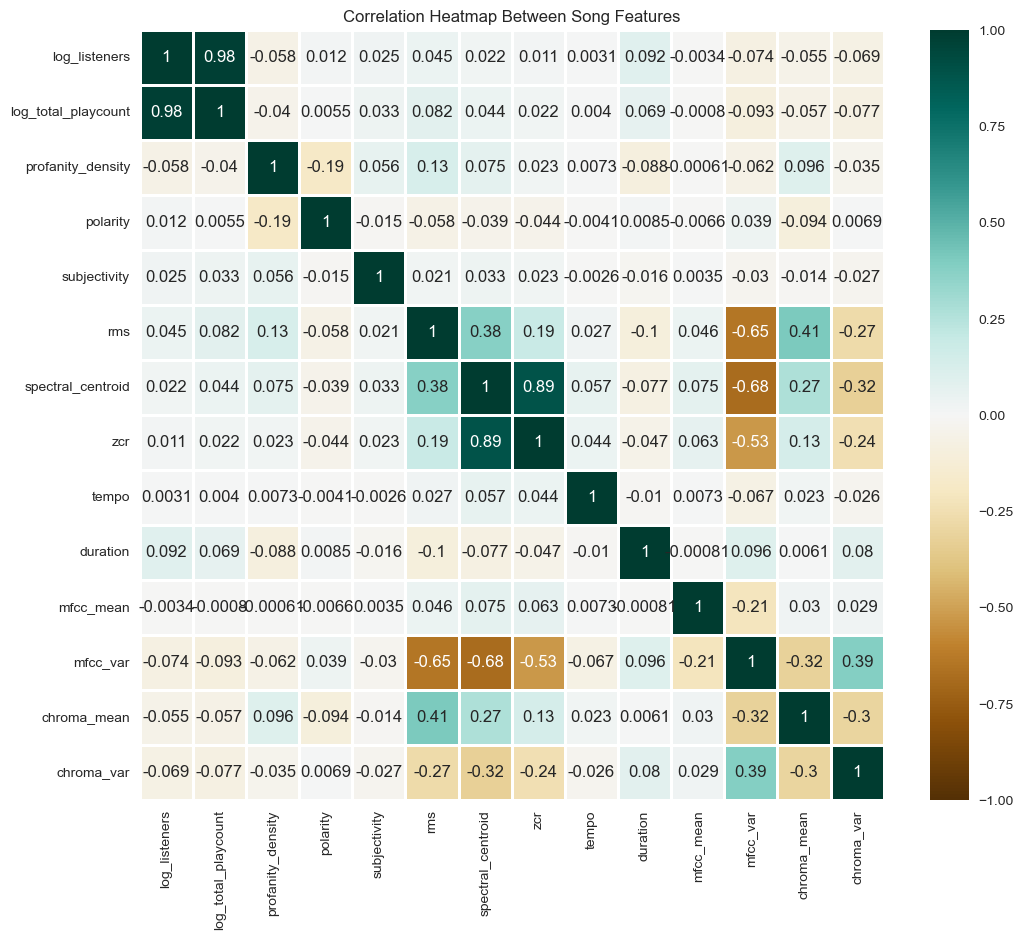

In [12]:
# heatmap to observe the correlation between numerical features 
plt.clf()
corr_df=songs_all[numerical_features].corr(method='pearson')
plt.figure(figsize=(12,10))
heatmap=sns.heatmap(corr_df, annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap="BrBG", linewidths=2)
heatmap.set_title('Correlation Heatmap Between Song Features')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.show()

We can see from the heatmap that some features are highly correlated. Next we use scatter plot to observe their correlation.

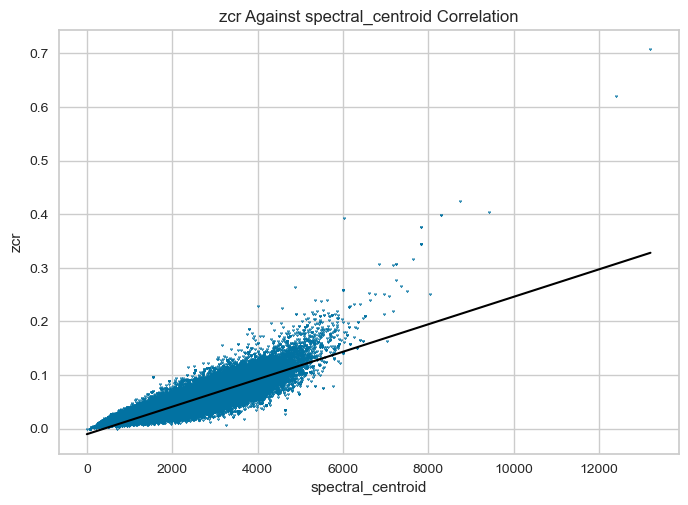

In [13]:
# observe the correlation between zcr and spectral_centroid audio features
plt.clf()
sns.regplot(data=songs_all, y='zcr', x='spectral_centroid', scatter_kws={'s':2}, marker='2', line_kws={"color": "black", 'linewidth':1.5}).set(title='zcr Against spectral_centroid Correlation')
plt.show()

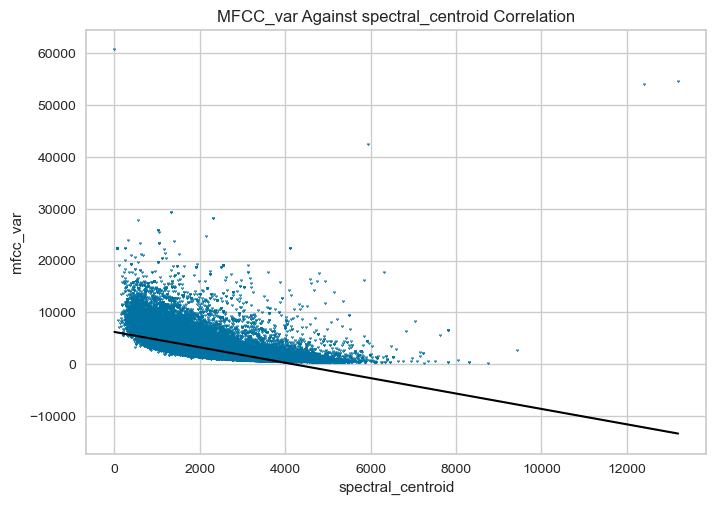

In [14]:
# observing the correlation between mfcc_var and spectral_centroid
plt.clf()
sns.regplot(data=songs_all, y='mfcc_var', x='spectral_centroid', scatter_kws={'s':2}, marker='2', line_kws={"color": "black", 'linewidth':1.5}).set(title='MFCC_var Against spectral_centroid Correlation')
plt.show()

There are 44779 unique artists. 
There are 9 unique top emotions among all the songs, we can consider use one-hot-encoding on this feature

In [30]:
print(songs_all[['artist_name_original']].nunique())
print(songs_all['emotion1'].value_counts())
# print(songs_all['emotion2'].value_counts())

artist_name_original    44779
dtype: int64
emotion1
positive    106086
negative     95865
fear          9541
trust         8473
sadness       5143
surprise      3489
anger         1021
disgust        711
joy            347
Name: count, dtype: int64


We can see that most listened-to songs have emotions like joy and anger

Text(0, 0.5, 'Mood')

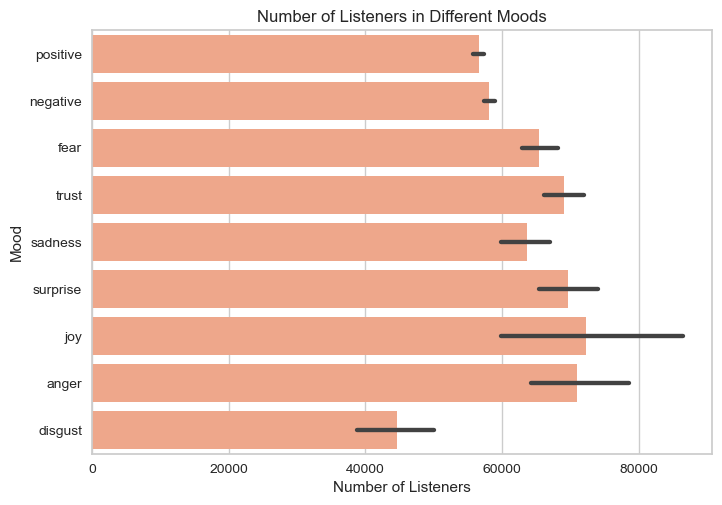

In [16]:
plt.title("Number of Listeners in Different Moods")
sns.barplot(y='emotion1', x='listeners', data=songs_all, color='lightsalmon')
plt.xlabel ("Number of Listeners")
plt.ylabel("Mood")

We can see that profanity_density is significantly higher in songs with negative, anger and disgust emotions.

Text(0, 0.5, 'Mood')

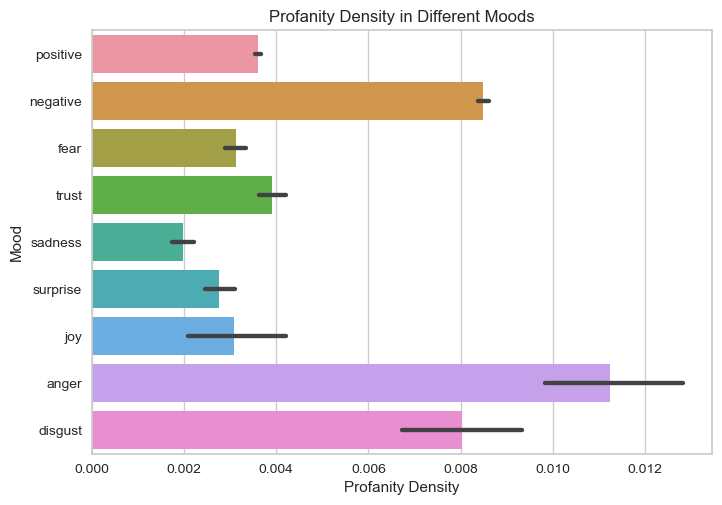

In [17]:
plt.clf()
plt.title("Profanity Density in Different Moods")
sns.barplot(y='emotion1', x='profanity_density', data=songs_all)
plt.xlabel ("Profanity Density")
plt.ylabel("Mood")

There are a large number (38493) of different tags for songs, as users are free to generate their own tags on Last.fm

It would not be so feasible to do one-hot-encoding or TFIDF on this feature

In [18]:
categories_flat = [category for sublist in songs_all['toptags'] for category in sublist]
# Count the occurrences of each category
category_counts = Counter(categories_flat)
ranked_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

ranked_categories_dict = dict(ranked_categories)
len(ranked_categories_dict)

38493

### Normalization and Dimensionality Reduction

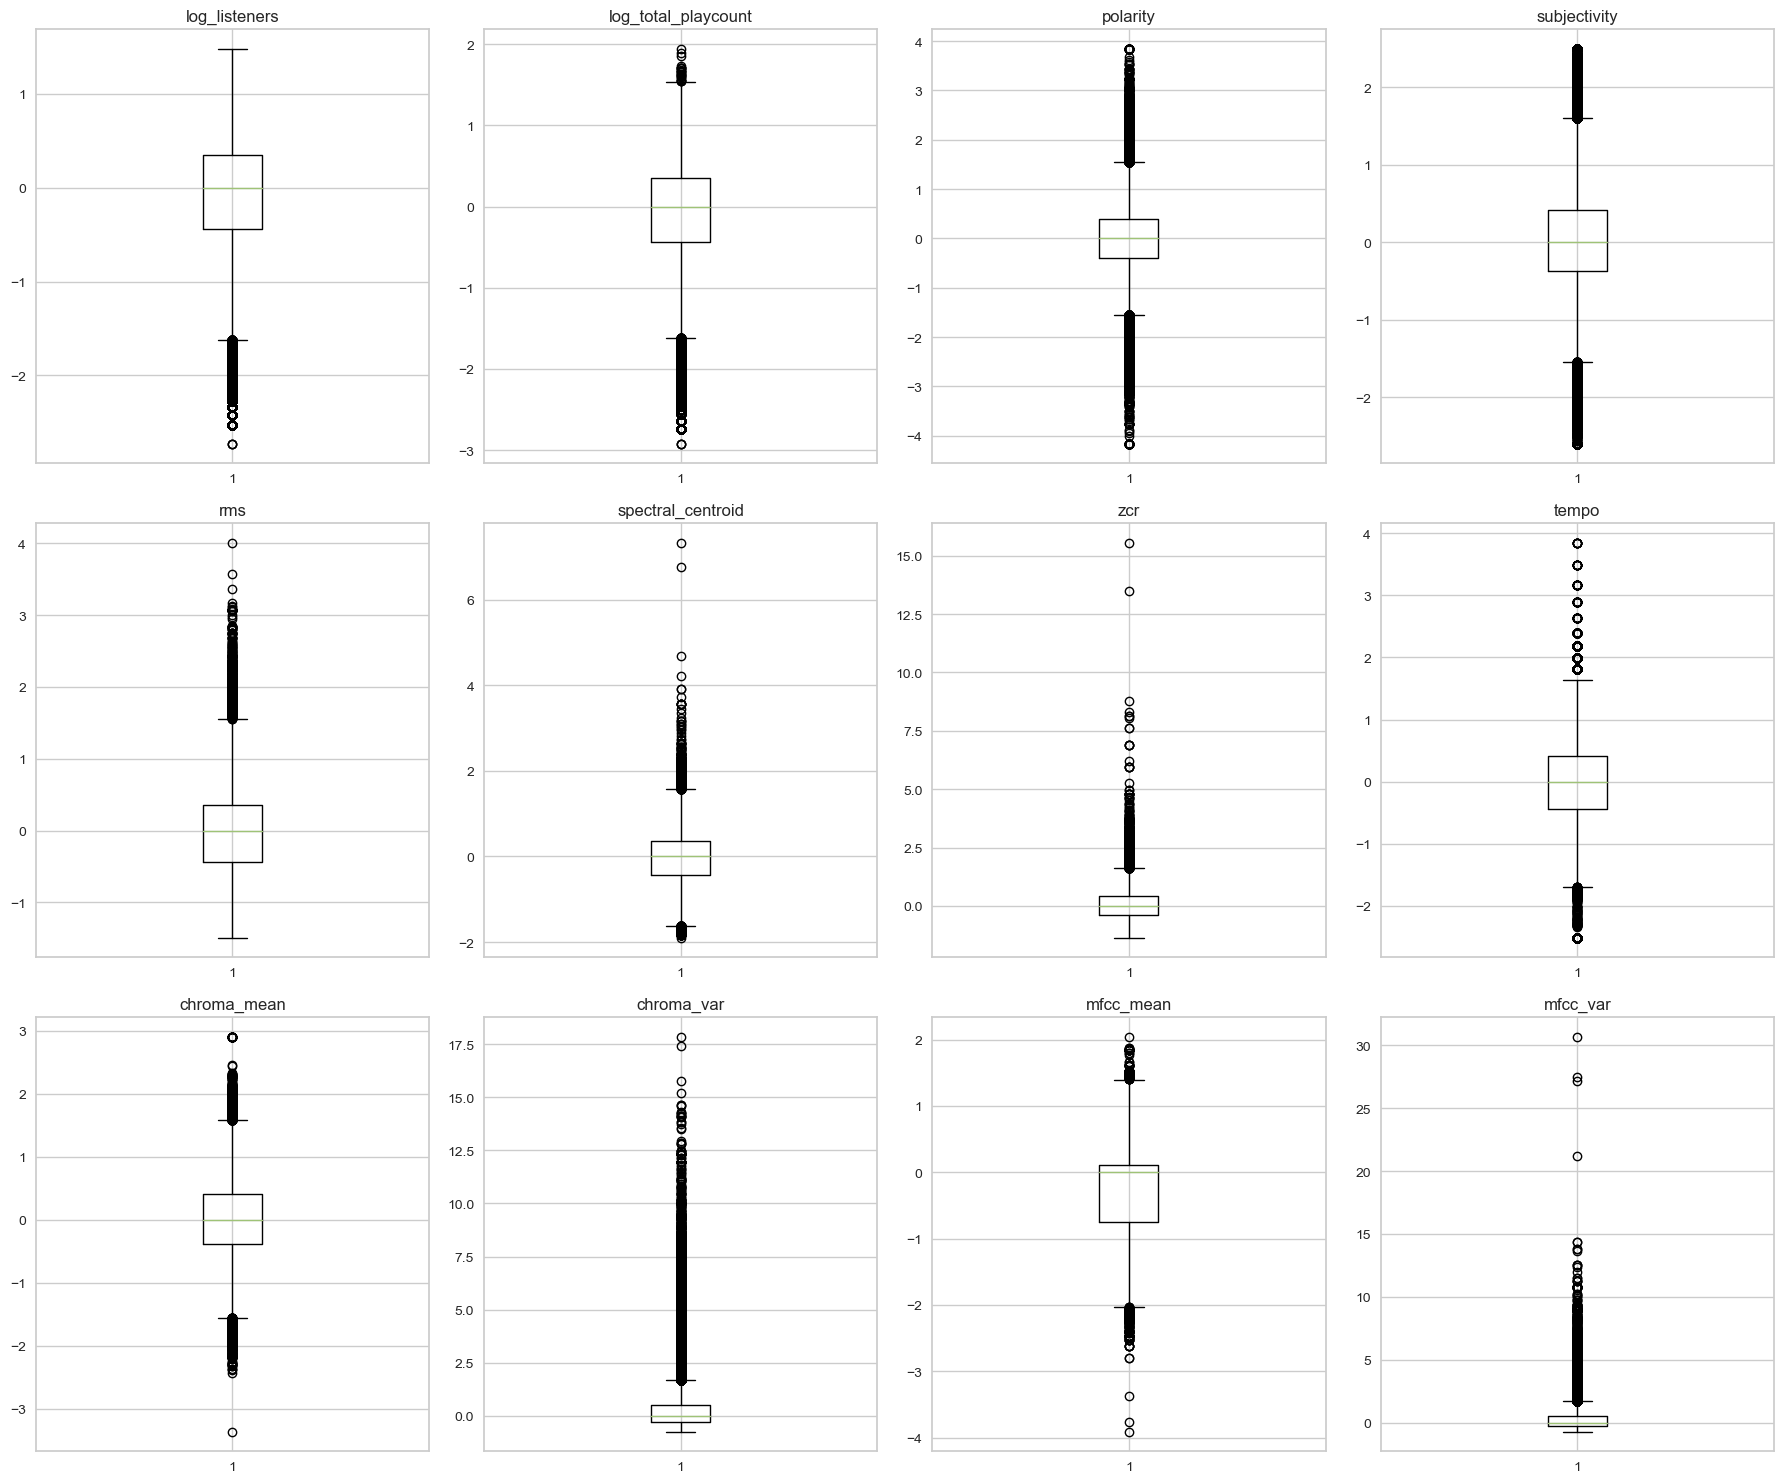

In [19]:
# numerical_features = ['listeners', 'total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'duration', 'mfcc_mean', 'mfcc_var', 'chroma_mean', 'chroma_var']
#  feature scaling
normalize_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 
                      'chroma_mean', 'chroma_var',
                      'mfcc_mean', 'mfcc_var'
                      ]
songs_all_normalize = songs_all[normalize_features].copy()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
scaler = RobustScaler(quantile_range = (20,80))

for i in songs_all[normalize_features].columns:
  songs_all_normalize[i] = scaler.fit_transform(songs_all_normalize[[i]])

# visualize the values after scaling
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))
axs = axs.flatten()
for i, feature in enumerate(songs_all_normalize.columns):
    axs[i].boxplot(songs_all_normalize[feature])
    axs[i].set_title(feature)
plt.tight_layout()
plt.show()

In [34]:
# since profanity_density and duration have many unique values, it makes sense to convert them into categorical using bins
# low: 0 - 33%
# medium: 33 - 66%
# high: 66 - 100%
# songs_all['duration_bin'] = pd.cut(songs_all['duration'], bins=3, labels=['short', 'medium', 'long'])
# songs_all['profanity_density_bin'] = pd.cut(songs_all['profanity_density'], bins=3, labels=['low', 'medium', 'high'])

# quantile-based binning for highly skewed feature values
songs_all['duration_bin'] = pd.qcut(songs_all['duration'], q=3, labels=['short', 'medium', 'long'])
songs_all['profanity_density_bin'] = pd.qcut(songs_all['profanity_density'].rank(method='first'), q=3, labels=['low', 'medium', 'high'])

one_hot = pd.get_dummies(songs_all[['duration_bin', 'profanity_density_bin', 'emotion1', 'emotion2']])
emotions = ['anger', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    one_hot[f'emotion_{emotion}'] = one_hot[f'emotion1_{emotion}'] + one_hot[f'emotion2_{emotion}']
one_hot.drop(columns=[f'emotion1_{emotion}' for emotion in emotions] + [f'emotion2_{emotion}' for emotion in emotions], inplace=True)
one_hot.tail()

,duration_bin_short,duration_bin_medium,duration_bin_long,profanity_density_bin_low,profanity_density_bin_medium,profanity_density_bin_high,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_negative,emotion_positive,emotion_sadness,emotion_surprise,emotion_trust
230671,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True
230672,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False
230673,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False
230674,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False
230675,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False


### feature generation pipeline

In [12]:
def convert_to_float_list(s):
    # extract floating-point numbers
    # float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d+", s)
    float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d*\.\d+\s*|\d+\s*", s)
    # convert to list of floats
    float_list = [float(num) for num in float_numbers]
    return float_list

def calculate_mean_var(lst):
    if len(lst) > 0:
        audio_mean = np.mean(lst)
        audio_var = np.var(lst)
        return audio_mean, audio_var
    else:
        return np.nan, np.nan

def audio_feature_scaling(ls):
    if len(ls) > 0:
        return sklearn.preprocessing.scale(ls)
    else:
        return ls

def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "_" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

def song_feature_eng(df, cols):
    df = df[cols]

    ## logarithmic transformation for values with large range
    df['log_total_playcount'] = np.log1p(df['total_playcount'])
    df['log_listeners'] = np.log1p(df['listeners'])
    
    ## transform audio features columns
    df['mfcc'] = df['mfcc'].apply(convert_to_float_list)
    df[['mfcc_mean', 'mfcc_var']] = pd.DataFrame(df['mfcc'].apply(calculate_mean_var).tolist(), index=df.index)
    df['mfcc_scaled'] = df['mfcc'].apply(audio_feature_scaling)
    df['mfcc_features'] = df['mfcc_scaled'].apply(lambda x: np.array(x).flatten())
    mfcc_features = np.stack(df['mfcc_features'])
    mfcc_features = pd.DataFrame(mfcc_features)
    mfcc_features.columns = [f'mfcc_{i+1}' for i in range(mfcc_features.shape[1])]
    
    df['chroma'] = df['chroma'].apply(convert_to_float_list)
    df[['chroma_mean', 'chroma_var']] = pd.DataFrame(df['chroma'].apply(calculate_mean_var).tolist(), index=df.index)

    ## normalize features
    normalize_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 
                          'chroma_mean', 'chroma_var',
                          'mfcc_mean', 'mfcc_var'
                          ]
    songs_all_normalize = df[normalize_features].reset_index(drop = True)
    # Robust Scaler algorithms scale features that are robust to outliers. The method it follows is almost similar to the MinMax Scaler but it uses 
    # the interquartile range (rather than the min-max used in MinMax Scaler). The median and scales of the data are removed by this scaling algorithm according to the quantile range.
    scaler = RobustScaler(quantile_range = (20,80))
    # scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(songs_all_normalize), columns = songs_all_normalize.columns) 

    ## one-hot encoding features
    df['duration_bin'] = pd.qcut(df['duration'], q=3, labels=['short', 'medium', 'long'])
    df['profanity_density_bin'] = pd.qcut(df['profanity_density'].rank(method='first'), q=3, labels=['low', 'medium', 'high'])

    profanity_ohe = ohe_prep(df, 'profanity_density_bin', 'profanity') *0.3
    duration_ohe = ohe_prep(df, 'duration_bin', 'duration')*0.3
    # emotion_ohe = ohe_prep(df, ['emotion1', 'emotion2'], 'emotion') 

    emotion_ohe = pd.get_dummies(df[['emotion1', 'emotion2']]) * 0.5
    emotions = ['anger', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
    for emotion in emotions:
        emotion_ohe[f'emotion_{emotion}'] = emotion_ohe[f'emotion1_{emotion}'] + emotion_ohe[f'emotion2_{emotion}']
    emotion_ohe.drop(columns=[f'emotion1_{emotion}' for emotion in emotions] + [f'emotion2_{emotion}' for emotion in emotions], inplace=True, axis=1)

    ## concat to create final df
    eng_df = pd.concat([floats_scaled, profanity_ohe, duration_ohe, emotion_ohe, mfcc_features, 
                        ], axis = 1)
    eng_df['track_name'] = df['track_name_original'].values
    eng_df['artist_name'] = df['artist_name_original'].values
    
    return eng_df

In [13]:
songs_all_eng = song_feature_eng(songs_all, songs_all.columns.tolist())
songs_all_eng.head()

,log_listeners,log_total_playcount,polarity,subjectivity,rms,spectral_centroid,zcr,tempo,chroma_mean,chroma_var,mfcc_mean,mfcc_var,profanity_low,profanity_medium,profanity_high,duration_short,duration_medium,duration_long,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_negative,emotion_positive,emotion_sadness,emotion_surprise,emotion_trust,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,track_name,artist_name
0,-0.167387,0.023660,-0.165781,-0.036365,0.370126,0.184518,0.131208,0.188372,-0.469478,0.272788,-0.099412,-0.258117,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,2.204978,3.307820,0.078024,0.901500,-0.408018,0.281305,-0.127647,-0.301641,-0.267857,-0.521158,-0.556605,-0.547993,-0.539712,-0.551469,-0.504613,-0.553963,-0.581009,-0.398014,-0.475994,-0.437934,One Look,Leo
1,0.469054,0.392145,-1.317889,0.779821,-0.464388,0.252576,0.488321,1.088372,0.210695,0.615360,0.025586,0.022412,0.0,0.0,0.3,0.0,0.0,0.3,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,3.189598,2.514374,0.321714,0.460685,-0.308175,0.271639,-0.473637,-0.400748,-0.399219,-0.355792,-0.519768,-0.490052,-0.386140,-0.476099,-0.514144,-0.509798,-0.529863,-0.498680,-0.510913,-0.384981,Cradle,Mudvayne
2,-0.221593,-0.191305,-0.659764,-0.850362,0.195520,0.466441,0.512684,1.212510,0.468074,-0.308705,-0.018932,-0.367260,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,1.689678,3.452519,0.831296,0.786983,-0.059200,0.200883,-0.186065,-0.099530,-0.373162,-0.250590,-0.585358,-0.571274,-0.668864,-0.535515,-0.659918,-0.666647,-0.668424,-0.518024,-0.570185,-0.548602,Reading YouTube Comments,Drug Church
3,0.363056,0.461095,-0.028703,0.399409,0.660554,0.452705,0.509389,-0.616891,-0.308621,0.108677,-0.025497,-0.381531,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.289903,3.767310,0.840891,1.123958,0.267804,0.308624,-0.233148,-0.050254,-0.335206,-0.269634,-0.684641,-0.396449,-0.603554,-0.618014,-0.549691,-0.572312,-0.465688,-0.628986,-0.493999,-0.696913,Tissues,YUNGBLUD
4,0.789597,0.921555,0.181731,-0.219415,0.542149,0.464976,0.385042,0.761099,-0.547521,0.138237,-0.057963,-0.369105,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,2.166070,3.167229,0.658349,0.816508,-0.021791,0.437930,-0.489586,-0.089056,-0.532748,-0.606704,-0.454009,-0.494834,-0.552256,-0.516542,-0.572312,-0.550454,-0.636744,-0.628570,-0.437318,-0.663161,The Games We Play,Pusha T


### PCA

Explained variance ratio of each component: [4.87468177e-01 1.50816245e-01 5.93692520e-02 5.06209219e-02
 3.69826925e-02 3.64765433e-02 3.48518242e-02 3.11985583e-02
 2.59882286e-02 2.30828392e-02 9.08398240e-03 6.77501066e-03
 5.42501229e-03 5.27289892e-03 4.26687378e-03 3.41080635e-03
 2.90979560e-03 2.32838831e-03 2.26318363e-03 2.12591134e-03
 2.08659809e-03 2.06815072e-03 1.85273795e-03 1.78596023e-03
 1.61788107e-03 1.25529311e-03 1.23526321e-03 7.95411892e-04
 7.71327363e-04 7.49154218e-04 6.80250622e-04 6.72684320e-04
 5.13851438e-04 4.90427510e-04 4.53702986e-04 4.47093038e-04
 3.83647744e-04 3.28659042e-04 2.72379599e-04 2.31440486e-04
 2.08601783e-04 1.95449664e-04 1.86888643e-04 9.61361468e-32
 3.64354124e-33 3.64354124e-33 3.64354124e-33]


<Figure size 800x550 with 0 Axes>

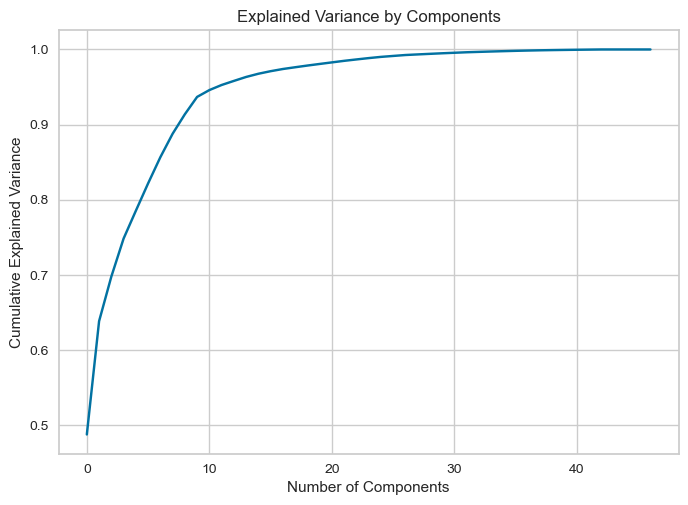

In [14]:
## PCA with feature engineering
numerical_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity',
                        'rms', 'spectral_centroid', 'zcr', 'tempo', 
                          'mfcc_mean', 'mfcc_var',         
                        'chroma_mean', 'chroma_var', 
                        'profanity_low', 'profanity_medium', 'profanity_high',
                        'duration_short', 'duration_medium', 'duration_long', 'emotion_anger',
                        'emotion_disgust', 'emotion_fear', 'emotion_joy', 'emotion_negative',
                        'emotion_positive', 'emotion_sadness', 'emotion_surprise', 'emotion_trust',  
                        'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 
                        'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14',
                        'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20',
                        ]
X = songs_all_eng[numerical_features]
pca = PCA()
X_pca = pca.fit_transform(X)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
plt.clf()
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

The results show that the first principal component explains 48.74% of the total variance in data. Combining the first six principal components, they can explain about 82.17% of total variance in the data.


We try to understand the PCA components. The components correspond to combinations of the original features, the components themselves are stored as an attribute of the fitted PCA object:

In [16]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)
pca.components_

array([[-4.68017455e-04, -1.13491717e-03, -2.01101803e-03,
        -2.04813605e-03,  2.72587938e-03, -1.89471719e-02,
        -1.15926692e-02, -1.68766714e-03, -1.98045600e-01,
         7.83092291e-02,  5.61289130e-03, -4.39240176e-03,
         1.94579017e-04,  2.69945733e-04, -4.64524750e-04,
        -5.67260213e-04,  2.39138081e-04,  3.28122132e-04,
        -2.45950040e-04, -9.31129335e-05,  4.44893864e-04,
        -6.35726324e-04,  6.90454907e-04, -6.47610518e-04,
         6.75671204e-04, -1.68574333e-04, -2.00458269e-05,
        -9.40968654e-01,  2.74516433e-02, -7.61906161e-02,
         5.39177560e-02,  1.99448239e-02,  6.37962403e-02,
         1.57500991e-02,  6.95322130e-02,  4.77370269e-02,
         6.88453763e-02,  5.89292012e-02,  6.96080948e-02,
         6.53906568e-02,  6.74781476e-02,  6.98574634e-02,
         6.12575049e-02,  7.08141244e-02,  6.04762372e-02,
         7.28033141e-02,  5.35693470e-02],
       [-5.19217819e-02, -5.96891575e-02,  3.55997656e-02,
        -2.11

In this numpy matrix array, each row represents a principal component, and each column relates back to the original features. we can visualize this relationship with a heatmap:

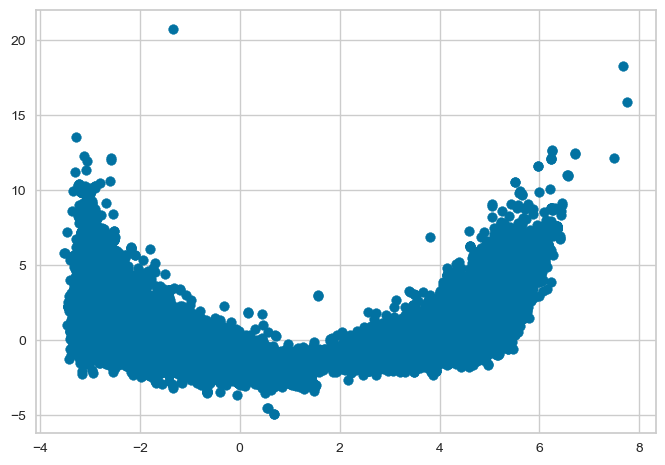

In [17]:
plt.scatter([i[0] for i in X_pca], [i[1] for i in X_pca])

<Axes: >

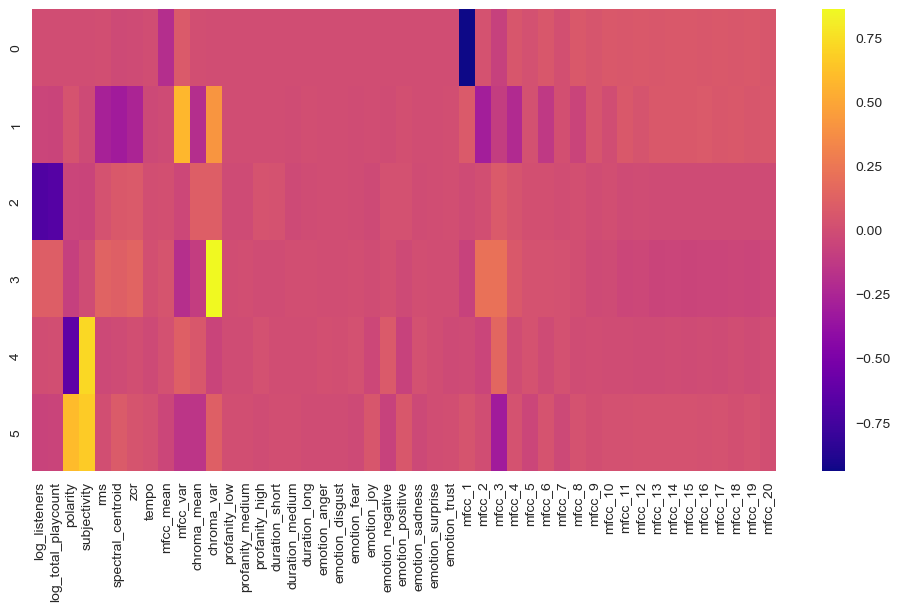

In [18]:
df_comp = pd.DataFrame(pca.components_,columns=numerical_features)
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

This heatmap and the color bar represent the correlation between the various feature and the principal component itself.

In [19]:
## saving a version of dataset with principal components
X = songs_all_eng[numerical_features]

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)
pc_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
result_df = pd.concat([X, pc_df], axis=1)
result_df['track_name'] = songs_all_eng['track_name'].values
result_df['artist_name'] = songs_all_eng['artist_name'].values
result_df.to_csv('songs_feature_eng_pca.csv', index=False)
joblib.dump(pca, 'pca_model.pkl')


['pca_model.pkl']

In [20]:
result_df.head()

,log_listeners,log_total_playcount,polarity,subjectivity,rms,spectral_centroid,zcr,tempo,mfcc_mean,mfcc_var,chroma_mean,chroma_var,profanity_low,profanity_medium,profanity_high,duration_short,duration_medium,duration_long,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_negative,emotion_positive,emotion_sadness,emotion_surprise,emotion_trust,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,PC1,PC2,PC3,PC4,PC5,PC6,track_name,artist_name
0,-0.167387,0.023660,-0.165781,-0.036365,0.370126,0.184518,0.131208,0.188372,-0.099412,-0.258117,-0.469478,0.272788,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,2.204978,3.307820,0.078024,0.901500,-0.408018,0.281305,-0.127647,-0.301641,-0.267857,-0.521158,-0.556605,-0.547993,-0.539712,-0.551469,-0.504613,-0.553963,-0.581009,-0.398014,-0.475994,-0.437934,-1.448596,-0.569393,-0.016804,0.335455,-0.061101,0.057167,One Look,Leo
1,0.469054,0.392145,-1.317889,0.779821,-0.464388,0.252576,0.488321,1.088372,0.025586,0.022412,0.210695,0.615360,0.0,0.0,0.3,0.0,0.0,0.3,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,3.189598,2.514374,0.321714,0.460685,-0.308175,0.271639,-0.473637,-0.400748,-0.399219,-0.355792,-0.519768,-0.490052,-0.386140,-0.476099,-0.514144,-0.509798,-0.529863,-0.498680,-0.510913,-0.384981,-2.433523,-0.022320,-0.594790,0.433389,1.437584,-0.308513,Cradle,Mudvayne
2,-0.221593,-0.191305,-0.659764,-0.850362,0.195520,0.466441,0.512684,1.212510,-0.018932,-0.367260,0.468074,-0.308705,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,1.689678,3.452519,0.831296,0.786983,-0.059200,0.200883,-0.186065,-0.099530,-0.373162,-0.250590,-0.585358,-0.571274,-0.668864,-0.535515,-0.659918,-0.666647,-0.668424,-0.518024,-0.570185,-0.548602,-1.074580,-1.403430,0.398831,0.141553,-0.098781,-1.219734,Reading YouTube Comments,Drug Church
3,0.363056,0.461095,-0.028703,0.399409,0.660554,0.452705,0.509389,-0.616891,-0.025497,-0.381531,-0.308621,0.108677,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.289903,3.767310,0.840891,1.123958,0.267804,0.308624,-0.233148,-0.050254,-0.335206,-0.269634,-0.684641,-0.396449,-0.603554,-0.618014,-0.549691,-0.572312,-0.465688,-0.628986,-0.493999,-0.696913,0.301323,-1.488867,-0.539187,0.851189,0.265387,0.105254,Tissues,YUNGBLUD
4,0.789597,0.921555,0.181731,-0.219415,0.542149,0.464976,0.385042,0.761099,-0.057963,-0.369105,-0.547521,0.138237,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,2.166070,3.167229,0.658349,0.816508,-0.021791,0.437930,-0.489586,-0.089056,-0.532748,-0.606704,-0.454009,-0.494834,-0.552256,-0.516542,-0.572312,-0.550454,-0.636744,-0.628570,-0.437318,-0.663161,-1.504924,-1.040311,-1.218933,0.622659,-0.393141,-0.040788,The Games We Play,Pusha T


Explained variance ratio of each component: [0.35899016 0.21182255 0.16331385 0.13863441 0.07247061 0.03058823
 0.01947048 0.00303303 0.00114403 0.00053265]


<Figure size 800x550 with 0 Axes>

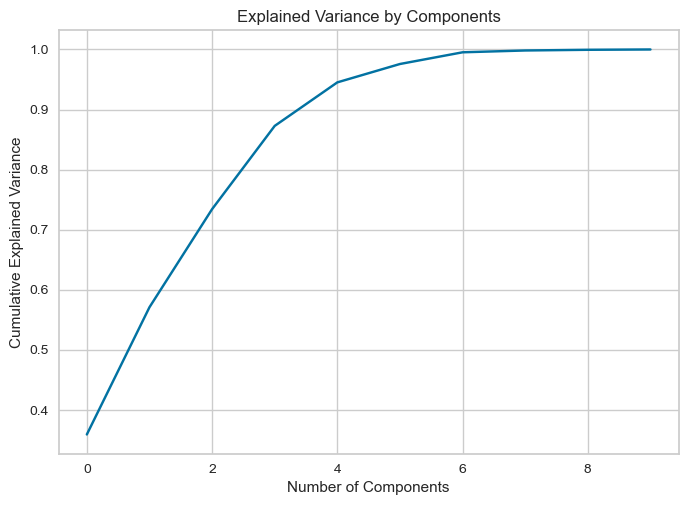

In [26]:
## PCA without feature engineering
numerical_features = ['listeners', 'total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'tempo', 'duration', 'spectral_centroid', 'rms', 'zcr']
X = songs_all[numerical_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
plt.clf()
plt.figure()
# View the explained variance ratio for each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# the results show that the first principal component explains 35.89% of the total variance in data
# combining the first four principal components, they can explain about 87.27% of total variance in the data.

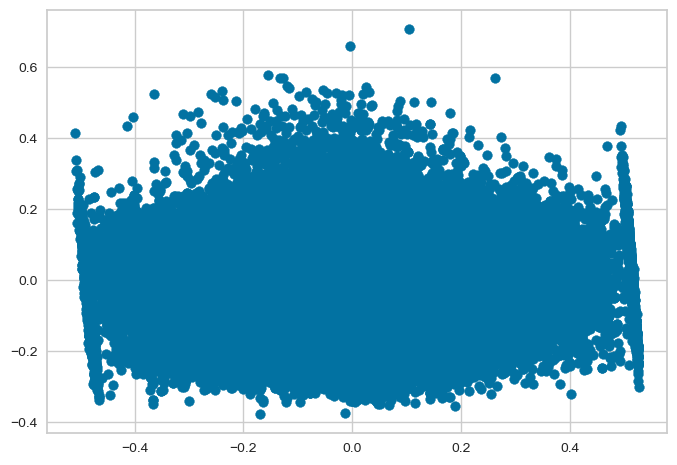

In [27]:
plt.scatter([i[0] for i in X_pca], [i[1] for i in X_pca])